In [1]:
from PIL import Image, ImageDraw, ImageFont
from transformers import LayoutLMv2Processor, LayoutLMv2ImageProcessor
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from pathlib import Path
import json
from collections import defaultdict
import pandas as pd
import numpy as np
import torch

## General exploration of the data structures and various functions from huggingface

In [2]:
# img_path = Path("../datasets/custom_youtube/white_bg/export/2024-03-13-20-58/images/613b5c04-yt_big_1.png")
img_path = Path("../datasets/custom/2.png")
image = Image.open(
        img_path
).convert("RGB")

width, height = image.size

In [3]:
#processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2ImageProcessor.from_pretrained("microsoft/layoutlmv2-base-uncased")

In [4]:
encoding = processor(
    image, return_tensors="pt"
)  # you can also add all tokenizer parameters here such as padding, truncation
print(encoding.keys())

dict_keys(['pixel_values', 'words', 'boxes'])


In [5]:
encoding.words

[['Pridejte',
  'komentaf.',
  'VSe',
  '84',
  'Moje',
  'komentare',
  'Zobrazit',
  'ptispévky:',
  'Od',
  'nejlepSich',
  'v',
  'S',
  'Petr',
  'Skiirek',
  '©',
  'Pied',
  '1',
  'rokem',
  'Vsak',
  'jim',
  'to',
  'rusove',
  'brzo',
  'tipnouSSeeee',
  'Odpovedét',
  '-',
  '@',
  ' @P',
  '21',
  'Jifi',
  'Pokorny',
  '@',
  '©',
  'Pred',
  '1',
  'rokem',
  '/',
  'Petr',
  'Skiirek',
  'Mrzenitko',
  'na',
  'strané',
  'ruSSkych',
  'kolaborantd',
  'je',
  'cim',
  'dal',
  'patrnéjai.',
  '@',
  'Ma',
  'z',
  'toho',
  'tipani',
  'mokré',
  'sny?',
  'Assmaz',
  'situ',
  'profilovku,',
  'jsi',
  'ostudou',
  'Sparty!',
  'Odpovedst',
  '-',
  '9',
  '|',
  'M4',
  'Zobrazit',
  'dali',
  'reakce',
  'o',
  'Karel',
  'KiiZanovsky',
  '@',
  '©',
  'Pred',
  '1',
  'rokem',
  'No',
  'to',
  'jsme',
  'radi,',
  'ale',
  'nelo',
  'to',
  'drive?',
  'Odpovadét',
  '-',
  '%',
  '(13',
  'gp',
  '208eF',
  'Fleischman»',
  'Pred',
  't',
  'rokem',
  'i',
  'O',

In [6]:
len(encoding.words[0])

627

#### LayoutMLv2 uses different normalization of bboxes than label studio

In [7]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def unnormalize_ls_box(bbox, width, height):
     return [
         width * (bbox[0] / 100),
         height * (bbox[1] / 100),
         width * (bbox[2] / 100),
         height * (bbox[3] / 100),
     ]

In [8]:
# def fix_y_coords(box):
#   return [box[0], box[3], box[2], box[1]]

# def fix_x_coords(box):
#   return [box[2], box[1], box[0], box[3]]

def draw_boxes(img: Image, boxes, norm = True):
  draw = ImageDraw.Draw(img)

  width, height = img.size

  for box in boxes:
    print(box)
    # if norm:
    box = unnormalize_ls_box(box, width, height)
    draw.rectangle(box, outline="blue", width=2)

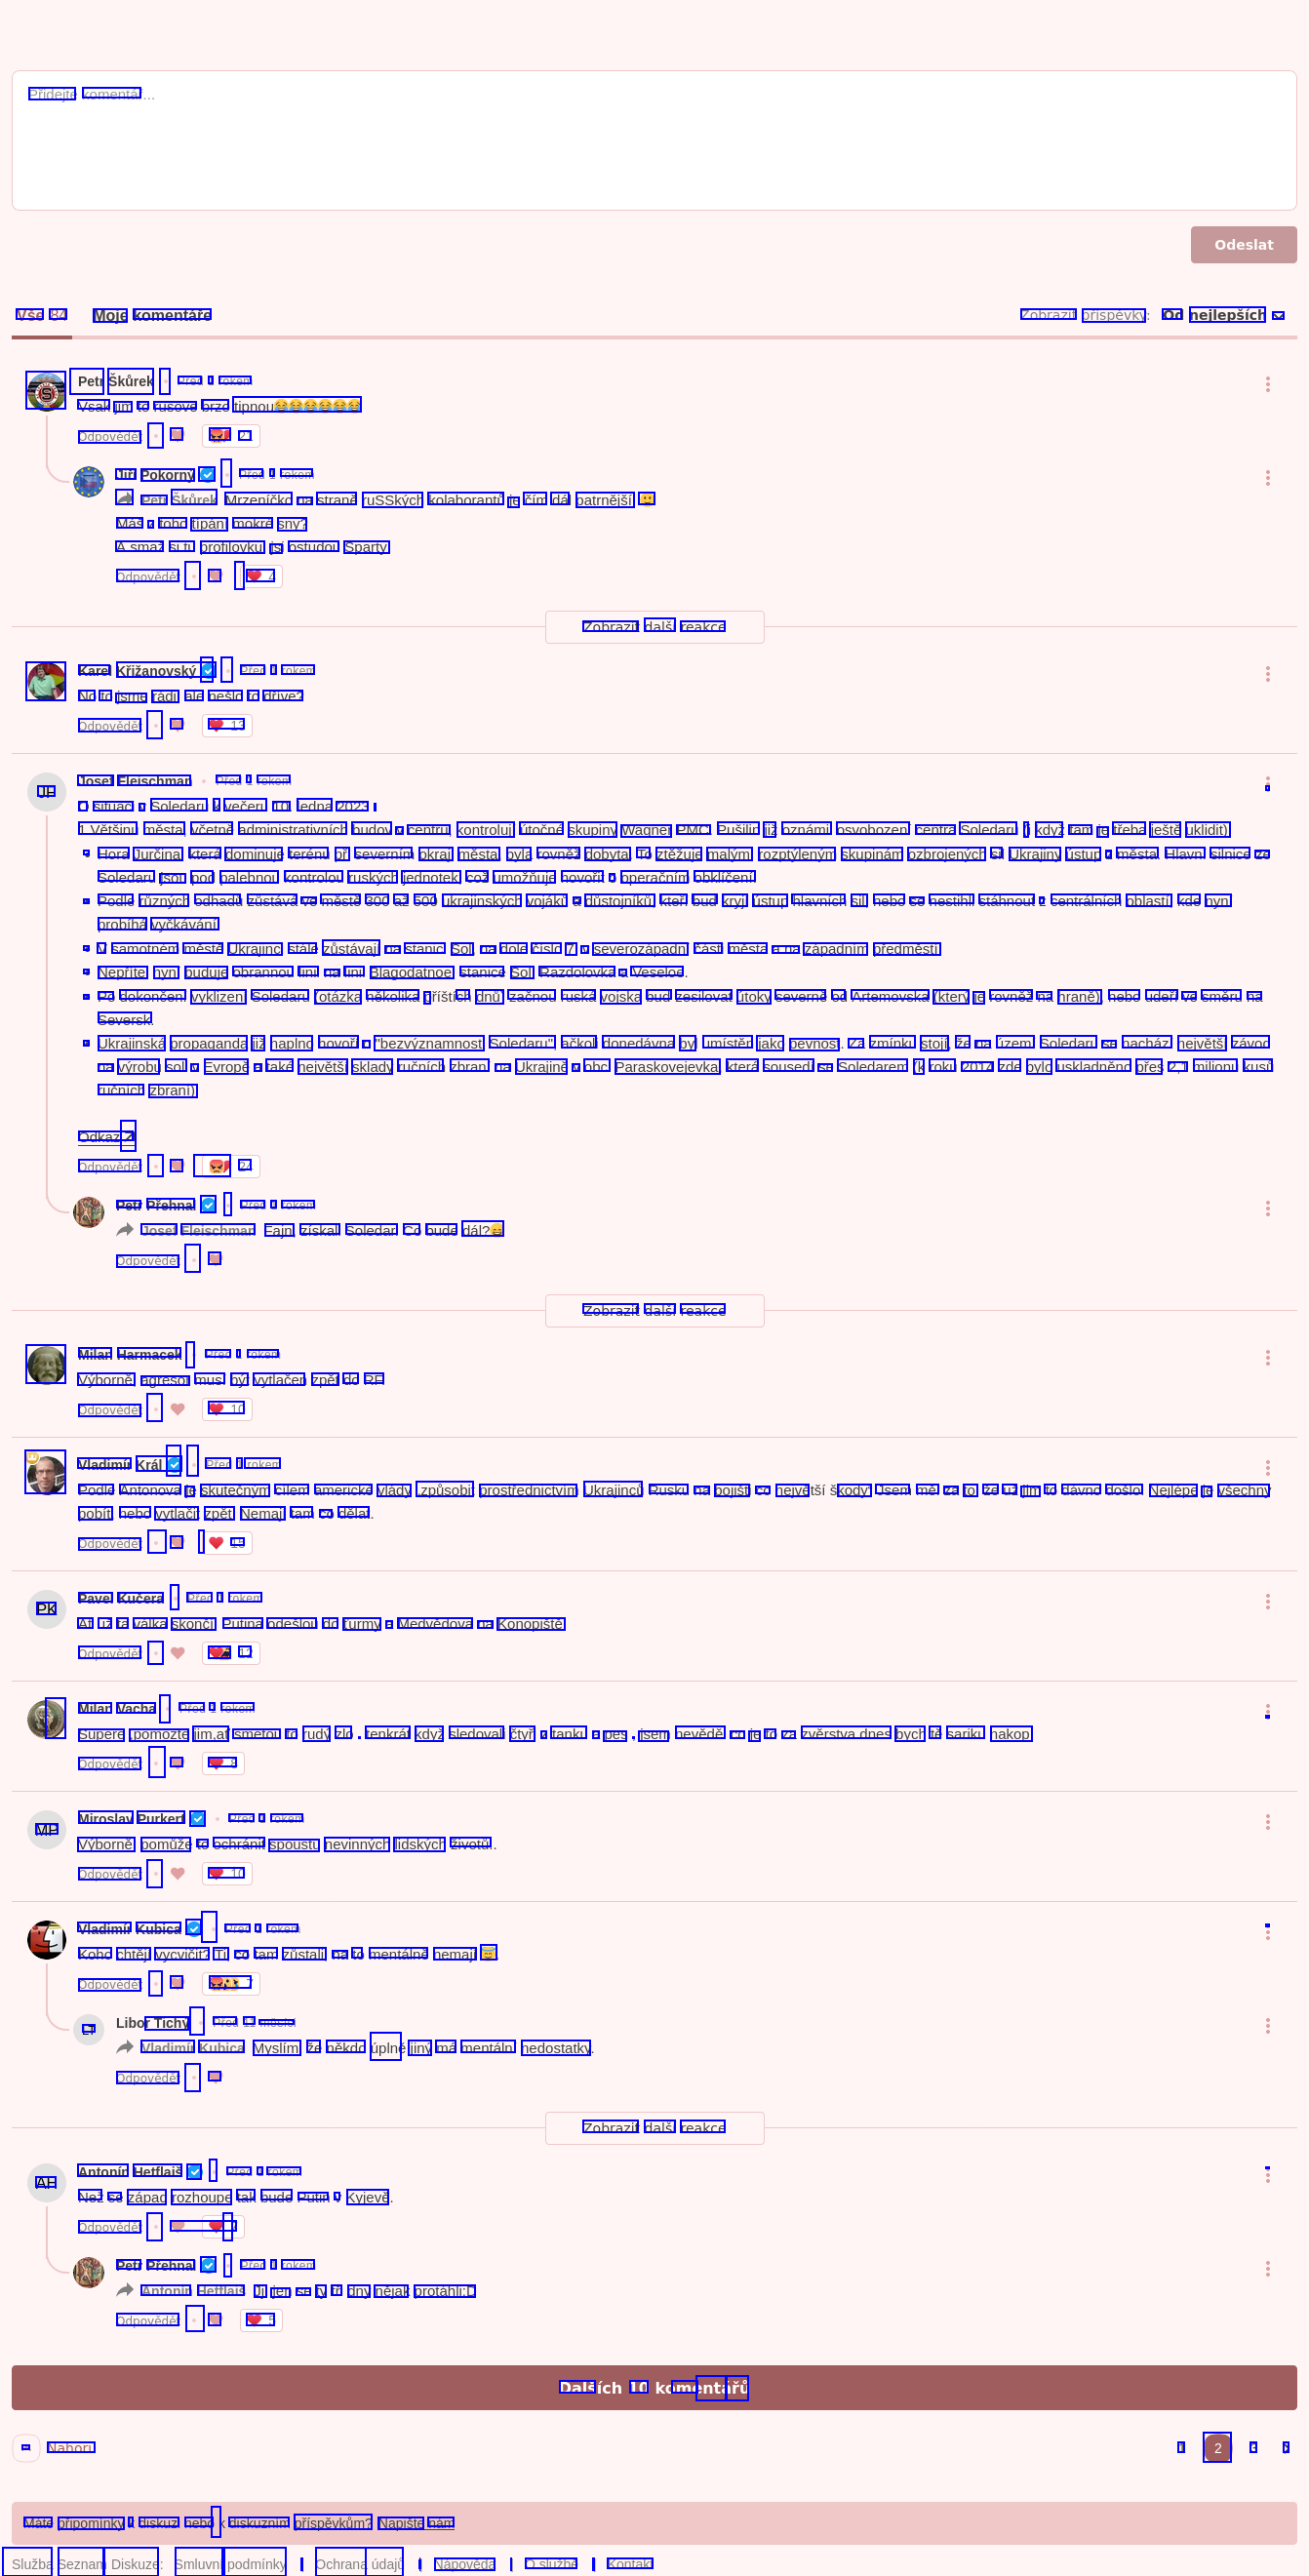

In [9]:
draw = ImageDraw.Draw(image)

# for box in encoding.bbox[0]:
for box in encoding.boxes[0]:
  # actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline="blue", width=2)
  # draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)


# box = unnormalize_box(encoding.boxes[0][0], width, height)
# draw.rectangle(box, outline="green", width=2)

image

### Dataset paths

In [10]:
# Original yt dataset
# COCO_PATH = Path("../datasets/custom_youtube/white_bg/export/2024-03-13-20-58") # using just for images, since their names are "mangled" by lable studio
# ANNOT_PATH = Path("../datasets/custom_youtube/white_bg/export/min-project-4-at-2024-03-13-19-53-af410d9e.json") # these are the actual annotations

COCO_PATH = Path("../datasets/custom_youtube/white_bg/export2/2024-04-10-17-08") # using just for images, since their names are "mangled" by lable studio
ANNOT_PATH = Path("../datasets/custom_youtube/white_bg/export2/min-project-4-at-2024-04-10-17-08-7e62dd88.json") # these are the actual annotations

In [11]:
# NOTE: can't get coco export from label studio to work
# Don't need to run this
# def prepare_coco_annotations(path: Path):

#   d = defaultdict(lambda: { "bbox": [], "image": None })

#   with open(path/"result.json", "r") as f:
#     results = json.load(f)

#     # print(results["categories"])
#     print(list(filter(lambda a: a["image_id"] == 0, results["annotations"])))
#     # print(results.keys())

#   for annot in results["annotations"]:
#     d[annot["image_id"]]["bbox"].append({ "box": annot["bbox"], "class_id": annot["category_id"] })

#   for img in results["images"]:
#     d[img["id"]]["image"] = img["file_name"].split("/")[1]

#   # print(d)

#   classes = {}
#   for cat in results["categories"]:
#     classes[cat["id"]] = cat["name"]

#   return (d, classes)


# # annots, id2cls_dict = prepare_coco_annotations(ANNOT_PATH)

Get the label studio export into some usable shape

In [12]:
def make_bbox(rect):
  return [rect["x"], rect["y"], rect["x"] + rect["width"], rect["y"] + rect["height"]]


cls2id = {
  "O": 0,
  "Body": 1,
  "Author": 2,
  "Date": 3
}
labels = list(cls2id.keys())

def prepare_annotations(path: Path):


  d = defaultdict(lambda: { "bbox": [], "image": None })

  with open(path, "r") as f:
    results = json.load(f)
    print(results)
    print(results[0].keys())

  for annot in results:
    for b in annot["label"]:
      d[annot["id"]]["bbox"].append({ "box": make_bbox(b), "class_id": cls2id[b["rectanglelabels"][0]] })
    d[annot["id"]]["image"] = annot["image"].split("/")[-1]

  # for img in results["images"]:
  #   d[img["id"]]["image"] = img["file_name"].split("/")[1]

  # print(d)

  classes = {}
  for n,i in cls2id.items():
    classes[i] = n

  return (d, classes)


annots, id2cls_dict = prepare_annotations(ANNOT_PATH)

[{'image': '/data/upload/4/613b5c04-yt_big_1.png', 'id': 8, 'label': [{'x': 10.387323943661972, 'y': 4.106606854240195, 'width': 45.86267605633803, 'height': 2.8746247979681367, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 17.384635682950158, 'width': 8.18661971830986, 'height': 3.148398588250817, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.29225352112676, 'y': 27.651152818550646, 'width': 80.36971830985917, 'height': 2.60085100768546, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 37.91766995415114, 'width': 7.922535211267604, 'height': 2.4639641125441187, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.556338028169016, 'y': 47.773526404327605, 'width': 20.686619718309856, 'height': 2.6008510076854563, 'rotation': 0, 'rec

In [13]:
cls2id

{'O': 0, 'Body': 1, 'Author': 2, 'Date': 3}

In [14]:
# TODO: i don't think this works properly right now
def calculate_iou(box1, box2):
    x0_inter = max(box1[0], box2[0])
    y0_inter = max(box1[1], box2[1])
    x1_inter = min(box1[2], box2[2])
    y1_inter = min(box1[3], box2[3])
    
    if x1_inter < x0_inter or y1_inter < y0_inter:
        return 0.0
    
    intersection_area = (x1_inter - x0_inter) * (y1_inter - y0_inter)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    
    return iou

### Create parent relation vector

In [15]:
for k,v in annots.items():
  print(k, v["image"])

8 613b5c04-yt_big_1.png
9 0f5358cf-yt_big_2.png
10 71735819-yt_big_3.png
11 aa355e0f-yt_big_4.png
12 89a239aa-yt_big_5.png
13 f7cacb8f-yt_big_6.png
14 79b8d86f-yt_big_7.png
15 186d4a34-yt_reply_1.png
16 8a5a8d75-yt_single_1.png
17 b162ee4f-yt_single_2.png
18 d16218e6-sz_1.png
19 31d31832-lidovky_1.png


In [16]:
Image.open(COCO_PATH / "images" / annots[19]["image"]).show()

In [17]:
def pad_or_truncate(some_list, target_len, val=0):
    return some_list[:target_len] + [val]*(target_len - len(some_list))

In [18]:
annot_rels = {}

# annot_rels[8] = torch.tensor([-1, 0, 0, 0, 0, -1, -1, -1])
# annot_rels[9] = torch.tensor([-1, -1, 1, -1, 3, -1, -100, -100])
# annot_rels[10] = torch.tensor([-1, 0, -1, 2, -1, -1, -1, -100])
# annot_rels[11] = torch.tensor([-1, 0, -1, -1, -1, -1, 5, -1])
# annot_rels[12] = torch.tensor([-1, -1, -1, -1, -1, -1, -100, -100])
# annot_rels[13] = torch.tensor([-1, -1, -1, 2, 2, 2, 2, -1])
# annot_rels[14] = torch.tensor([-1, 0, 1, -100, -100, -100, -100, -100])
# annot_rels[15] = torch.tensor([-1, 0, -100, -100, -100, -100, -100, -100])
# annot_rels[16] = torch.tensor([-1, -100, -100, -100, -100, -100, -100, -100])
# annot_rels[17] = torch.tensor([-1, -100, -100, -100, -100, -100, -100, -100])
# annot_rels[18] = torch.tensor([-1, 0, -1, -1, -1, 4, -100, -100])
# annot_rels[19] = torch.tensor([-1, 0, -1, 2, -100, -100, -100, -100])

ANNOT_REL_LEN = 100


annot_rels[8] =  [-1, 0, 0, 0, 0, -1, -1, -1]
annot_rels[9] =  [-1, -1, 1, -1, 3, -1, -100, -100]
annot_rels[10] = [-1, 0, -1, 2, -1, -1, -1, -100]
annot_rels[11] = [-1, 0, -1, -1, -1, -1, 5, -1]
annot_rels[12] = [-1, -1, -1, -1, -1, -1, -100, -100]
annot_rels[13] = [-1, -1, -1, 2, 2, 2, 2, -1]
annot_rels[14] = [-1, 0, 1, -100, -100, -100, -100, -100]
annot_rels[15] = [-1, 0, -100, -100, -100, -100, -100, -100]
annot_rels[16] = [-1, -100, -100, -100, -100, -100, -100, -100]
annot_rels[17] = [-1, -100, -100, -100, -100, -100, -100, -100]
annot_rels[18] = [-1, 0, -1, -1, -1, 4, -100, -100]
annot_rels[19] = [-1, 0, -1, 2, -100, -100, -100, -100]


list(map(len, annot_rels.values()))


for k, v in annot_rels.items():
  annot_rels[k] = pad_or_truncate(v, ANNOT_REL_LEN, -100)

annot_rels


{8: [-1,
  0,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100],
 9: [-1,
  -1,
  1,
  -1,
  3,
  -1,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -

### See how OCR bboxes and manual label overlap

In [19]:
print(annots)
for k,v in annots.items():
  print(k, v["image"])

defaultdict(<function prepare_annotations.<locals>.<lambda> at 0x7fca95483010>, {8: {'bbox': [{'box': [10.387323943661972, 4.106606854240195, 56.25, 6.981231652208332], 'class_id': 1}, {'box': [13.380281690140844, 17.384635682950158, 21.566901408450704, 20.533034271200975], 'class_id': 1}, {'box': [13.29225352112676, 27.651152818550646, 93.66197183098592, 30.252003826236106], 'class_id': 1}, {'box': [13.380281690140844, 37.91766995415114, 21.30281690140845, 40.381634066695256], 'class_id': 1}, {'box': [13.556338028169016, 47.773526404327605, 34.24295774647887, 50.37437741201306], 'class_id': 1}, {'box': [10.387323943661972, 58.99825180591747, 35.91549295774648, 61.73598970874426], 'class_id': 1}, {'box': [10.299295774647888, 74.1926971666062, 33.274647887323944, 76.79354817429164], 'class_id': 1}, {'box': [10.387323943661972, 89.38714252729491, 37.852112676056336, 91.85110663983903], 'class_id': 1}, {'box': [21.390845070422536, 1.9164165319787578, 26.76056338028169, 3.559059273674836],

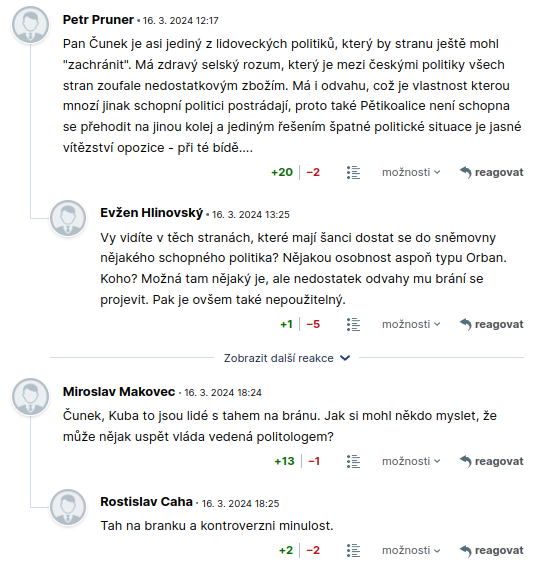

In [20]:
Image.open(COCO_PATH / "images" / annots[19]["image"])

[[17.941092299415047, 90.21601016518424, 60.50207768123905, 93.51969504447268], [11.000377760225282, 70.77509529860228, 90.75311652185857, 78.01778907242694], [17.548221665121286, 39.7712833545108, 92.19364218093571, 54.510800508259216], [10.476550247833602, 5.336721728081321, 95.07469349908995, 27.573062261753496], [17.941092299415047, 86.40406607369758, 35.09644333024257, 89.32655654383736], [11.262291516421124, 66.83608640406608, 31.822521377794565, 69.75857687420584], [17.417264787023363, 35.45108005082592, 36.66792586741761, 38.75476493011436], [10.345593369735683, 0.7623888182973316, 24.357979326213126, 4.8284625158831], [36.66792586741761, 86.6581956797967, 50.549354945797134, 89.1994917407878], [33.00113328067585, 67.21728081321474, 48.19213114003457, 69.75857687420584], [38.23940840459265, 36.0864040660737, 52.513708117265935, 38.75476493011436], [25.667548107192328, 2.1601016518424396, 40.46567533225729, 4.701397712833545]]
[17.941092299415047, 90.21601016518424, 60.502077681

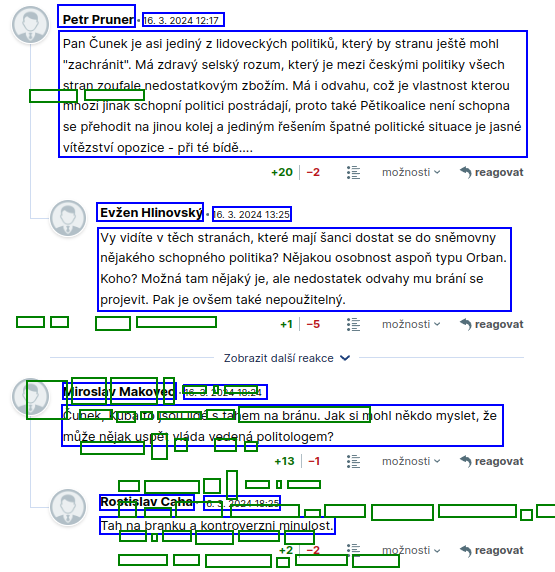

In [21]:
img = Image.open(COCO_PATH / "images" / annots[19]["image"]).convert("RGB")


boxes = list(map(lambda b: b["box"], annots[19]["bbox"]))
print(list(boxes))

draw_boxes(img, boxes, False)

draw = ImageDraw.Draw(img)

for box in encoding.boxes[0]:
  # actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline="green", width=2)

img

### Mark OCR bboxes with corresponding labels (based on manual label "blocks" from label studio)

In [22]:

anot = annots[8]
img = Image.open(COCO_PATH / "images" / anot["image"]).convert("RGB")


# boxes = list(map(lambda b: b["box"], anot["bbox"]))
# print(list(boxes))

def classify_bboxes(img: Image, encoding, anot):

  width, height = img.size

  ner_tags  = []
  for i,box in enumerate(encoding.boxes[0]):
    # print(block)
    ner_tags.append(0)

    for block in anot["bbox"]:
      iou = calculate_iou(unnormalize_ls_box(block["box"], width, height), unnormalize_box(box, width, height)) # TODO: fix iou -- don't think it works
      # print(iou)

      if iou > 0: # there is some overlap -- mark it with that label (iou doesn't seem to work properly...)
        ner_tags[i] = block["class_id"]


  # print(ner_tags)
  return ner_tags

In [23]:

def draw_classified_boxes(image, labels, boxes):
  draw = ImageDraw.Draw(image)

  font = ImageFont.load_default()

  # def iob_to_label(label):
  #     label = label[2:]
  #     if not label:
  #       return 'other'
  #     return label

  label2color = {'Author':'blue', 'Body':'green', 'Date':'orange', 'O':'violet'}
  se_label = {
      0: "",
      1: " start",
      2: " end",
  }

  for prediction, box in zip(labels, boxes):
      predicted_label = prediction # iob_to_label(prediction).lower()
      draw.rectangle(box, outline=label2color[predicted_label])
      draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

  return image

In [24]:
def visualize_classified_boxes():
  img = Image.open(COCO_PATH / "images" / annots[18]["image"]).convert("RGB")
  anot = annots[18]


  width, height = img.size

  encoding = processor(img, return_tensors="pt")
  print(encoding.boxes)

  labels = classify_bboxes(img, encoding, anot)

  labels = [id2cls_dict[l] for l in labels]

  boxes = [unnormalize_box(box, width, height) for box in encoding.boxes[0]]
    

  draw_classified_boxes(img, labels, boxes)

visualize_classified_boxes()

[[[388, 767, 406, 779], [427, 21, 469, 32], [474, 21, 511, 32], [534, 22, 558, 32], [564, 22, 576, 32], [580, 22, 629, 32], [941, 23, 944, 41], [428, 52, 476, 63], [479, 52, 521, 63], [519, 38, 535, 75], [535, 38, 551, 75], [555, 52, 603, 67], [606, 54, 625, 67], [629, 52, 645, 63], [649, 52, 701, 67], [705, 52, 732, 63], [737, 52, 747, 63], [751, 52, 798, 67], [803, 52, 835, 67], [840, 52, 870, 63], [875, 52, 934, 63], [427, 78, 466, 89], [470, 78, 528, 89], [532, 78, 566, 93], [570, 78, 612, 89], [616, 80, 625, 89], [629, 78, 687, 89], [697, 78, 714, 89], [718, 78, 764, 89], [769, 78, 802, 89], [806, 78, 883, 93], [888, 78, 934, 93], [938, 80, 944, 89], [427, 105, 496, 117], [500, 105, 570, 120], [574, 105, 619, 120], [622, 105, 660, 118], [665, 105, 684, 117], [688, 108, 696, 117], [698, 105, 774, 117], [777, 92, 786, 129], [788, 105, 806, 120], [810, 105, 846, 117], [851, 105, 912, 120], [915, 105, 942, 120], [427, 132, 466, 143], [469, 134, 481, 146], [485, 132, 562, 146], [567, 1

In [25]:
draw = ImageDraw.Draw(img)

id2color = {
  0: "black",
  1: "green",
  2: "blue",
  3: "yellow"
}

# for i,box in enumerate(encoding.boxes[0]):
#   # actual_label = iob_to_label(id2label[label]).lower()
#   box = unnormalize_box(box, width, height)
#   draw.rectangle(box, outline=id2color[ner_tags[i]], width=2)

# img

## Create dataset

In [26]:
from torch.utils.data import DataLoader
from datasets import Dataset

def make_dataset(annots):
  words = []
  boxes = []
  images = []
  word_labels = []
  start_end = []
  parent_rels = []

  processor = LayoutLMv2ImageProcessor.from_pretrained("microsoft/layoutlmv2-base-uncased")

  for id,val in annots.items():
    # val["bbox"] # list
    # val["image"] # base name

    image = Image.open(COCO_PATH / "images" / val["image"]).convert("RGB")

    # TODO: could this be done for all images at one time?
    encoding = processor(image, return_tensors="pt")  # you can also add all tokenizer parameters here such as padding, truncation
    
    ner_tags = classify_bboxes(image, encoding, val)

    start_end_local = []
    inside = False
    last = ""
    for c in ner_tags:
      if c == cls2id["Author"] and not inside:
        inside = True
        start_end_local.append(1) # start of comment
      elif c == cls2id["O"] and last == cls2id["Body"] and inside:
        start_end_local[-1] = 2 # end of comment (is the previous word)
        start_end_local.append(0) # current one should be ignored
        inside = False
      else:
        start_end_local.append(0) # ignore -- inside of comment
      last = c
    start_end.append(start_end_local)

    print(start_end_local)

    parent_rels.append(annot_rels[id])

    words.append(encoding.words[0])
    boxes.append(encoding.boxes[0])
    images.append(val["image"])
    word_labels.append(ner_tags)

    print(val["image"])




  ds = Dataset.from_pandas(pd.DataFrame({ 
    "image": images,
    "words": words,
    "boxes": boxes,
    "word_labels": word_labels,
    "id": id,
    "start_end": start_end,
    "parent_rels": parent_rels
  }))

  return ds

# make_dataset(annots)

In [27]:
annots, id2cls_dict = prepare_annotations(ANNOT_PATH)

ds = make_dataset(annots)

ds



[{'image': '/data/upload/4/613b5c04-yt_big_1.png', 'id': 8, 'label': [{'x': 10.387323943661972, 'y': 4.106606854240195, 'width': 45.86267605633803, 'height': 2.8746247979681367, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 17.384635682950158, 'width': 8.18661971830986, 'height': 3.148398588250817, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.29225352112676, 'y': 27.651152818550646, 'width': 80.36971830985917, 'height': 2.60085100768546, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 37.91766995415114, 'width': 7.922535211267604, 'height': 2.4639641125441187, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.556338028169016, 'y': 47.773526404327605, 'width': 20.686619718309856, 'height': 2.6008510076854563, 'rotation': 0, 'rec

Dataset({
    features: ['image', 'words', 'boxes', 'word_labels', 'id', 'start_end', 'parent_rels'],
    num_rows: 12
})

In [28]:

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=labels)),
    'start_end_labels': Sequence(ClassLabel(names=labels)),
    'parent_rels': Sequence(Value(dtype='int64')),
})

# def preprocess_data(boxes, words, ner_tags, img_path):
def preprocess_data(examples):
  print("ex:", (examples["words"]))
  image = [Image.open(COCO_PATH / "images" / path).convert("RGB") for path in examples["image"]]
  # image = Image.open(COCO_PATH / "images" / examples["image"]).convert("RGB")
  # words = words
  # boxes = boxes
  # word_labels = ner_tags
  
  encoded_inputs = processor(image, examples["words"], boxes=examples["boxes"], word_labels=examples["word_labels"],
                             padding="max_length", truncation=True)
  encoded_inputs_start_end = processor(image, examples["words"], boxes=examples["boxes"], word_labels=examples["start_end"],
                             padding="max_length", truncation=True)
  encoded_inputs["start_end_labels"] = encoded_inputs_start_end["labels"]
  encoded_inputs["parent_rels"] = examples["parent_rels"]
  
  # print("aaaaaa", encoded_inputs["start_end_labels"])
  
  return encoded_inputs

# train_dataset = datasets['train'].map(preprocess_data, batched=True, remove_columns=datasets['train'].column_names,
#                                       features=features)


train_dataset = ds.map(preprocess_data, batched=True, features=features, batch_size=5, remove_columns=ds.column_names)

# sample = preprocess_data(encoding.boxes[0], encoding.words[0], ner_tags, anot["image"])

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

ex: [['9', '@Jonathandelarosa1199', '1', 'month', 'ago', "There's", 'something', 'adorable', 'about', 'little', 'Sam', 'call', 'ty', 'DB', 'reply', '1g', 'Matt', 'and', 'Marisha,', 'Mr.', 'Matt', 'and', 'Ms.', 'Marisha.', '*', '4replies', 'e', '@SLorraineE', '1', 'month', 'ago', 'Yes!!!', 'So', 'cute!', 'Oe', 'GB', 'Reply', '@', '@DragonElixion', '1', 'month', 'ago', 'Look...', 'l', 'thought', 'the', 'same', 'thing', 'too...', 'then', '|', 'remembered', 'that', 'a', 'few', 'episodes', 'back', 'Marisha', 'suggested', 'it', 'was', 'the', 'start', 'of', 'their', 'throuple...', 'and', 'now', 'I', "don't", 'know', 'how', 'to', 'feel.', 'oe', 'BF', 'Reply', '6', '@Shakeandbake1990', '1', 'month', 'ago', 'Itwas', 'adorable', 'OP', 'Reply', '2', '@Grifter-2005', '1', 'month', 'ago', 'It', 'was', 'cute', 'until', 'big', 'Sam', 'said', 'miss', 'Marisha', 'oe', 'BF', 'Reply', '@GrayArmyGaming', '1', 'month', 'ago', '(edited)', 'Yes!ll!', "Sam's", "son's", 'imitation', 'of', 'Sam', 'was', 'brillia

### Verify sample

In [29]:
print(processor.tokenizer.decode(train_dataset[0]['input_ids']))
print(train_dataset[0]['labels'])
print(train_dataset[0]['start_end_labels'])
print(train_dataset[0]['parent_rels'])

train_dataset

[CLS] 9 @ jonathandelarosa1199 1 month ago there's something adorable about little sam call ty db reply 1g matt and marisha, mr. matt and ms. marisha. * 4replies e @ slorrainee 1 month ago yes!!! so cute! oe gb reply @ @ dragonelixion 1 month ago look... l thought the same thing too... then | remembered that a few episodes back marisha suggested it was the start of their throuple... and now i don't know how to feel. oe bf reply 6 @ shakeandbake1990 1 month ago itwas adorable op reply 2 @ grifter - 2005 1 month ago it was cute until big sam said miss marisha oe bf reply @ grayarmygaming 1 month ago ( edited ) yes! ll! sam's son's imitation of sam was brilliant! & 25 % gd reply ~ 60replies @ numbernine5894 1 month ago | adore that sam's son is captioned as ‘ lil sam ’ 1 550 gb reply ~ reply @ chandlerfaye 1 month ago travis's overwhelming delight over sam's son was a treat 75 dd reply + treply [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels', 'start_end_labels', 'parent_rels'],
    num_rows: 12
})

In [30]:
train_dataset.set_format(type="torch")

In [31]:
train_dataset.features.keys()

dict_keys(['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels', 'start_end_labels', 'parent_rels'])

create loader

In [32]:
  
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=2)

In [33]:
# look at a batch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  print(k, v.shape)

image torch.Size([2, 3, 224, 224])
input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
token_type_ids torch.Size([2, 512])
bbox torch.Size([2, 512, 4])
labels torch.Size([2, 512])
start_end_labels torch.Size([2, 512])
parent_rels torch.Size([2, 100])


### Custom LayoutLMv2 with two classifictation heads -- one for actual word classes and one for word grouping into comments

In [34]:
from typing import Optional, Tuple, Union
from torch import nn

from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers import LayoutLMv2PreTrainedModel, LayoutLMv2Model
from transformers.utils import ModelOutput
from transformers.modeling_outputs import TokenClassifierOutput

from dataclasses import dataclass


@dataclass
class TokenClassifier2Output(ModelOutput):
    """
    Base class for outputs of token classification models.

    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `labels` is provided) :
            Classification loss.
        logits (`torch.FloatTensor` of shape `(batch_size, sequence_length, config.num_labels)`):
            Classification scores (before SoftMax).
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    """

    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    start_end_logits: torch.FloatTensor = None
    parent_rels_logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None



class LayoutLMv2ForCustomClassification(LayoutLMv2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.layoutlmv2 = LayoutLMv2Model(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.start_end_classifier = nn.Linear(config.hidden_size, 3)
        # self.par_rel1 = nn.Conv2d(1, 2)
        # self.par_rel2 = nn.Conv2d(2, 1)
        self.par_rel1 = nn.Linear(7, 50)
        self.par_rel2 = nn.Linear(50, 100)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.layoutlmv2.embeddings.word_embeddings

    # @add_start_docstrings_to_model_forward(LAYOUTLMV2_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    # @replace_return_docstrings(output_type=TokenClassifierOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        bbox: Optional[torch.LongTensor] = None,
        image: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        start_end_labels: Optional[torch.LongTensor] = None, # NOTE: Added
        parent_rels: Optional[torch.LongTensor] = None, # NOTE: Added
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.

        Returns:

        Example:

        ```python
        >>> from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification, set_seed
        >>> from PIL import Image
        >>> from datasets import load_dataset

        >>> set_seed(88)

        >>> datasets = load_dataset("nielsr/funsd", split="test")
        >>> labels = datasets.features["ner_tags"].feature.names
        >>> id2label = {v: k for v, k in enumerate(labels)}

        >>> processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")
        >>> model = LayoutLMv2ForTokenClassification.from_pretrained(
        ...     "microsoft/layoutlmv2-base-uncased", num_labels=len(labels)
        ... )

        >>> data = datasets[0]
        >>> image = Image.open(data["image_path"]).convert("RGB")
        >>> words = data["words"]
        >>> boxes = data["bboxes"]  # make sure to normalize your bounding boxes
        >>> word_labels = data["ner_tags"]
        >>> encoding = processor(
        ...     image,
        ...     words,
        ...     boxes=boxes,
        ...     word_labels=word_labels,
        ...     padding="max_length",
        ...     truncation=True,
        ...     return_tensors="pt",
        ... )

        >>> outputs = model(**encoding)
        >>> logits, loss = outputs.logits, outputs.loss

        >>> predicted_token_class_ids = logits.argmax(-1)
        >>> predicted_tokens_classes = [id2label[t.item()] for t in predicted_token_class_ids[0]]
        >>> predicted_tokens_classes[:5]
        ['B-ANSWER', 'B-HEADER', 'B-HEADER', 'B-HEADER', 'B-HEADER']
        ```
        """

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.layoutlmv2(
            input_ids=input_ids,
            bbox=bbox,
            image=image,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]
        # only take the text part of the output representations
        sequence_output = outputs[0][:, :seq_length]
        sequence_output = self.dropout(sequence_output)

        # print(sequence_output.size())

        logits = self.classifier(sequence_output)

        
        start_end_logits = self.start_end_classifier(sequence_output) # TODO: try using the image outputs also?

        # print(seq_length)
        # print(logits.size())
        # print(start_end_logits.size())



        # both_logits = torch.cat((logits, start_end_logits), dim=2)
        # print(both_logits.size())

        # rel_logits1 = self.par_rel1(both_logits)
        # rel_logits = self.par_rel2(rel_logits1)

        # print(rel_logits.size())



        loss = None
        if labels is not None and start_end_labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            loss_start_end = loss_fct(start_end_logits.view(-1, 3), start_end_labels.view(-1))
            # print(start_end_logits.view(-1, 3).size(), start_end_labels.size())
            # print(rel_logits.view(seq_length, -1).size(), parent_rels.view(-1).size())
            # loss_rel = MSELoss()(rel_logits.view(seq_length, -1).float(), parent_rels.view(-1).float())
            # loss = (loss + loss_start_end + (loss_rel/2)) / 3
            loss = (loss + loss_start_end) / 2
        elif labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifier2Output(
            loss=loss,
            logits=logits,
            start_end_logits=start_end_logits,
            parent_rels_logits=None,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


### Train the model

In [35]:
import gc
model = None
trainer = None
gc.collect()

32

In [36]:
# copied from Fine_tuning_LayoutLMv2ForToeknClassification_on_FUNSD_using_HuggingFace_Trainer.ipynb
from transformers import LayoutLMv2ForTokenClassification, TrainingArguments, Trainer
from datasets import load_metric
import numpy as np


# torch.cuda.empty_cache()

model = LayoutLMv2ForCustomClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                                      num_labels=len(cls2id))

# Set id2label and label2id 
model.config.id2label = id2cls_dict
model.config.label2id = cls2id

# Metrics
metric = load_metric("seqeval")
return_entity_level_metrics = True

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2cls_dict[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2cls_dict[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

class CommentTrainer(Trainer):
    def get_train_dataloader(self):
      return train_dataloader

    def get_test_dataloader(self, test_dataset):
    #   return test_dataloader
      return train_dataloader

# torch.cuda.set_device(0)

args = TrainingArguments(
    output_dir="layoutlmv2-finetuned-yt-group2-v2", # name of directory to store the checkpoints
    max_steps=50, # we train for a maximum of 1,000 batches
    warmup_ratio=0.1, # we warmup a bit
    # fp16=True, # we use mixed precision (less memory consumption)
    push_to_hub=False, 
)

# print(args.device)

# model = model.to(args.device)

# Initialize our Trainer
trainer = CommentTrainer(
    model=model,
    args=args,
    compute_metrics=compute_metrics,
)

torch.cuda.empty_cache()

Some weights of LayoutLMv2ForCustomClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'par_rel1.bias', 'par_rel1.weight', 'par_rel2.bias', 'par_rel2.weight', 'start_end_classifier.bias', 'start_end_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1807579/1241050541.py:17: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/home/filip/fit/knn/proj/venv/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingf

# Actual training happens here

In [37]:
trainer.train()

  0%|          | 0/50 [00:00<?, ?it/s]

{'train_runtime': 899.179, 'train_samples_per_second': 0.445, 'train_steps_per_second': 0.056, 'train_loss': 0.7520293426513672, 'epoch': 8.33}


TrainOutput(global_step=50, training_loss=0.7520293426513672, metrics={'train_runtime': 899.179, 'train_samples_per_second': 0.445, 'train_steps_per_second': 0.056, 'train_loss': 0.7520293426513672, 'epoch': 8.33})

In [40]:
trainer.save_model()

### Should use a test_dataset, I don't have one right now

In [80]:

predictions, labels, metrics = trainer.predict(train_dataset)

***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  0%|          | 0/5 [00:00<?, ?it/s]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (2, 10, 512) + inhomogeneous part.

In [41]:
print(metrics)

{'test_loss': 0.047826625406742096, 'test_ate_precision': 1.0, 'test_ate_recall': 0.98, 'test_ate_f1': 0.98989898989899, 'test_ate_number': 50, 'test_ody_precision': 0.9983766233766234, 'test_ody_recall': 1.0, 'test_ody_f1': 0.9991876523151909, 'test_ody_number': 1230, 'test_uthor_precision': 1.0, 'test_uthor_recall': 0.9814814814814815, 'test_uthor_f1': 0.9906542056074767, 'test_uthor_number': 54, 'test_overall_precision': 0.9985007496251874, 'test_overall_recall': 0.9985007496251874, 'test_overall_f1': 0.9985007496251874, 'test_overall_accuracy': 0.9987908101571947, 'test_runtime': 1.1007, 'test_samples_per_second': 9.085, 'test_steps_per_second': 1.817}


In [42]:
print(predictions)
print(labels)

[[[ 0.42578125  1.0712891  -0.15490723 -1.9033203 ]
  [-0.66015625 -0.7055664   2.4042969  -0.6376953 ]
  [-0.6303711  -0.68603516  2.3886719  -0.6845703 ]
  ...
  [ 2.84375    -0.8911133  -0.8125     -0.86865234]
  [ 2.5878906  -0.88134766 -0.50390625 -0.9555664 ]
  [ 2.8476562  -0.88623047 -0.8286133  -0.859375  ]]

 [[ 1.2197266   0.4025879  -0.3527832  -1.5693359 ]
  [-0.69677734 -0.67285156  2.4023438  -0.6245117 ]
  [-0.70458984 -0.6611328   2.390625   -0.6254883 ]
  ...
  [ 2.7363281  -0.82470703 -0.70654297 -1.0097656 ]
  [ 2.2363281  -0.5649414  -0.5966797  -1.0605469 ]
  [ 2.828125   -0.8330078  -0.8066406  -0.96972656]]

 [[ 0.21398926  1.7763672  -1.0869141  -1.9003906 ]
  [ 2.8554688  -0.9121094  -0.7739258  -0.88720703]
  [ 2.8535156  -0.8886719  -0.79833984 -0.88916016]
  ...
  [ 2.8457031  -0.89990234 -0.7763672  -0.8964844 ]
  [ 2.8261719  -0.90283203 -0.73876953 -0.9135742 ]
  [ 2.8476562  -0.88671875 -0.80615234 -0.88378906]]

 ...

 [[-0.7705078   2.4550781  -1.2001

## Inference using a single image

In [42]:
from transformers import AutoModelForTokenClassification

# model = AutoModelForTokenClassification.from_pretrained("./layoutlmv2-finetuned-yt-v2/checkpoint-1000")
# model = LayoutLMv2ForCustomClassification.from_pretrained("./layoutlmv2-finetuned-yt-group2-v2/checkpoint-1000")
model = LayoutLMv2ForCustomClassification.from_pretrained("./layoutlmv2-finetuned-yt-group2-v2/")

In [43]:

# NOTE: custom text and bboxes can be suplied, see parameter: use_ocr=False
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

In [58]:
# img_path = Path("../datasets/custom_youtube/white_bg/data/yt_new_big_1.png")
# img_path = Path("../datasets/custom_sz/sz_1.png")
img_path = Path("../datasets/custom/novinky_1_large_p1_2.png")
# img_path = Path("../datasets/custom/sk_dennikn_1.png")
image = Image.open(
        img_path
).convert("RGB")

width, height = image.size

In [59]:
encoding = processor(
    image, return_tensors="pt", return_offsets_mapping=True
)  # you can also add all tokenizer parameters here such as padding, truncation
print(encoding.keys())

offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())
print(len(encoding.bbox[0]))
# print(len(encoding["input_ids"][0]))
# encoding.to("cuda") # can move to GPU -- have to move both encoding and the model below

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'bbox', 'image'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])
360


In [60]:
# model = model.to("cuda")
with torch.no_grad():
  outputs = model(**encoding)

In [61]:
print(outputs.logits.shape)

predictions = outputs.logits.argmax(-1).squeeze().tolist()
start_end_predictions = outputs.start_end_logits.argmax(-1).squeeze().tolist()
# rel_predictions = outputs.parent_rels_logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2cls_dict[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_start_end_predictions = [pred for idx, pred in enumerate(start_end_predictions) if not is_subword[idx]]
# true_rel_predictions = [pred for idx, pred in enumerate(rel_predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

print(true_predictions)
print(true_start_end_predictions)
print(true_boxes)    
# print(len(rel_predictions), rel_predictions)
# print(len(true_rel_predictions), true_rel_predictions)

torch.Size([1, 360, 4])
['Body', 'Body', 'Body', 'O', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'O', 'O', 'Body', 'Body', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body',

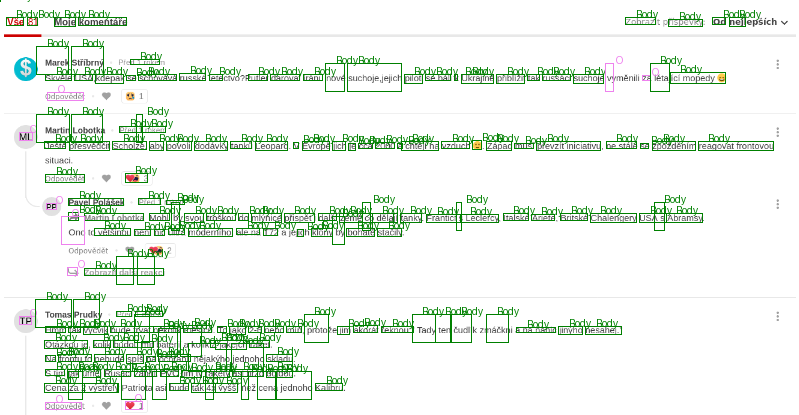

In [62]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

# def iob_to_label(label):
#     label = label[2:]
#     if not label:
#       return 'other'
#     return label

label2color = {'Author':'blue', 'Body':'green', 'Date':'orange', 'O':'violet'}
se_label = {
    0: "",
    1: " start",
    2: " end",
}

for prediction, se_prediction, box in zip(true_predictions, true_start_end_predictions, true_boxes):
    predicted_label = prediction # iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label + se_label[se_prediction], fill=label2color[predicted_label], font=font)

image